In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/roberta-finetuned"

sys.path.insert(0, ABSOLUTE_PATH)

# Fine-tuning RoBERTa model

In [3]:
import os

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    XLMRobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.metrics import classification_report

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

## Loading the model and tokenizer

In [4]:
MODEL_NAME = "xlm-roberta-base"
NUM_LABELS = 2
BATCH_SIZE = 8
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01
LEARNING_RATE = 2e-6
EARLY_STOPPING = 3

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def freeze_base_model(model):
  """
  Freeze all parameters except the classifier head.
  Only parameters whose names start with "classifier" will require gradients.
  """
  for name, param in model.named_parameters():
    if not name.startswith("classifier"):
      param.requires_grad = False

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Loading the preprocessed data

In [7]:
# Import splits of the dataset (train, val, test)
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"))
)

# Concatenate split sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,screen_name,text,account.type,class_type,text_tokens
0,imranyebot,YEA note GOOD,bot,others,yea note good
1,zawvrk,Listen Charming Man Smiths <URL>,human,human,listen charm man smith <url>
2,zawarbot,wish would seeing hoes worst part,bot,others,wish would see hoe worst part
3,ahadsheriffbot,decade significantly easier schedule like h…,bot,others,decad significantli easier schedul like h …
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,""" theim class =\ "" alignnon size-ful wp-imag -..."


In [8]:
from sklearn.model_selection import train_test_split

print("\nLabel distribution:")
print(train_df['account.type'].value_counts())
print(train_df['account.type'].value_counts(normalize=True))
print()
print(val_df['account.type'].value_counts())
print(val_df['account.type'].value_counts(normalize=True))
print()
print(test_df['account.type'].value_counts())
print(test_df['account.type'].value_counts(normalize=True))

# shrink to 10%, but keep same pos/neg ratio
_, train_df = train_test_split(
    train_df,
    train_size=0.95,
    stratify=train_df['account.type'],
    random_state=42
)

_, val_df = train_test_split(
    val_df,
    train_size=0.95,
    stratify=val_df['account.type'],
    random_state=42
)

_, test_df = train_test_split(
    test_df,
    train_size=0.95,
    stratify=test_df['account.type'],
    random_state=42
)

print("\nLabel distribution 2:")
print(train_df['account.type'].value_counts())
print(train_df['account.type'].value_counts(normalize=True))
print()
print(val_df['account.type'].value_counts())
print(val_df['account.type'].value_counts(normalize=True))
print()
print(test_df['account.type'].value_counts())
print(test_df['account.type'].value_counts(normalize=True))


Label distribution:
account.type
human    10358
bot      10354
Name: count, dtype: int64
account.type
human    0.500097
bot      0.499903
Name: proportion, dtype: float64

account.type
bot      1152
human    1150
Name: count, dtype: int64
account.type
bot      0.500434
human    0.499566
Name: proportion, dtype: float64

account.type
bot      1280
human    1278
Name: count, dtype: int64
account.type
bot      0.500391
human    0.499609
Name: proportion, dtype: float64

Label distribution 2:
account.type
human    518
bot      518
Name: count, dtype: int64
account.type
human    0.5
bot      0.5
Name: proportion, dtype: float64

account.type
bot      58
human    58
Name: count, dtype: int64
account.type
bot      0.5
human    0.5
Name: proportion, dtype: float64

account.type
human    64
bot      64
Name: count, dtype: int64
account.type
human    0.5
bot      0.5
Name: proportion, dtype: float64


In [9]:
text_column = 'text_tokens' # if 'text_tokens' in train_df.columns else 'text'

X_train = train_df[text_column].values
y_train = (train_df['account.type'] == 'bot').astype(int).values
print(X_train.shape, y_train.shape)
X_val = val_df[text_column].values
y_val = (val_df['account.type'] == 'bot').astype(int).values

X_test = test_df[text_column].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

train_dataset = TweetDataset(X_train, y_train, tokenizer, 512)
val_dataset = TweetDataset(X_val, y_val, tokenizer, 512)
test_dataset = TweetDataset(X_test, y_test, tokenizer, 512)

(1036,) (1036,)


## Training the model

In [10]:
training_args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to=["tensorboard"],
    # metric_for_best_model=metric_name,
)

# compute_loss - to override one must create custom trainer class
# and override the method compute_loss(self, model, inputs, return_outputs=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(
        AdamW(model.parameters(), lr=LEARNING_RATE), None),
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING)],
)

<ipython-input-10-8e91ac588823>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.662803,0.750000
2,No log,0.576443,0.784483
3,No log,0.527704,0.793103
4,0.632300,0.463054,0.810345
5,0.632300,0.424218,0.810345
6,0.632300,0.408718,0.818965
7,0.632300,0.403478,0.827586
8,0.511100,0.397136,0.827586
9,0.511100,0.393948,0.827586
10,0.511100,0.394953,0.836207


TrainOutput(global_step=1300, training_loss=0.5505733783428486, metrics={'train_runtime': 1229.9882, 'train_samples_per_second': 8.423, 'train_steps_per_second': 1.057, 'total_flos': 2725830533529600.0, 'train_loss': 0.5505733783428486, 'epoch': 10.0})

In [ ]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.5455194115638733,
 'eval_accuracy': 0.7572321891784668,
 'eval_runtime': 62.4993,
 'eval_samples_per_second': 40.928,
 'eval_steps_per_second': 5.12,
 'epoch': 10.0}

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [ ]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1278
           1       0.77      0.73      0.75      1280

    accuracy                           0.76      2558
   macro avg       0.76      0.76      0.76      2558
weighted avg       0.76      0.76      0.76      2558



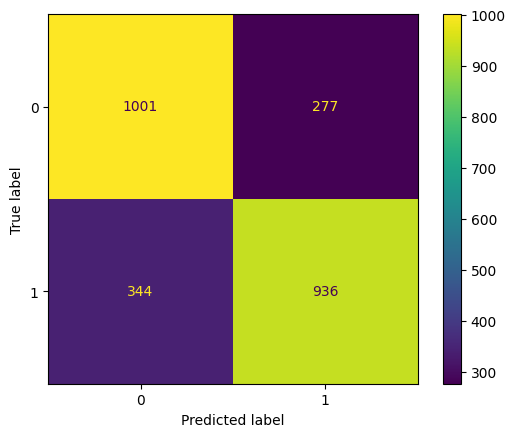

In [ ]:
plot_confusion_matrix(y_test, predicted_labels)